# Efficient Graph Based Segmentation

#### Importation des bibliothèques nécessaires

In [1]:
import cv2 as cv
import numpy as np
import os
from skimage import data
import imutils
import mahotas as mt
import matplotlib.pyplot as plt
from random import random 
import PIL
from PIL import Image, ImageFilter
from collections import Counter
import tensorflow as tf
from tensorflow import keras

## Préparation des données

##### Chargement de l'image utilisée comme premier test

In [2]:
def preprocess_image(file):
    image_file = Image.open(file)
    dim = (128, 128)
    smooth = image_file.filter(ImageFilter.GaussianBlur(1.0))
    smooth = np.array(smooth)
    test_img = cv.resize(smooth, dim, interpolation = cv.INTER_AREA)
    test_img = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
    return test_img

In [3]:
def read_color_image(file):
    i = cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB)
    return cv.resize(i, (128,128), interpolation = cv.INTER_AREA)

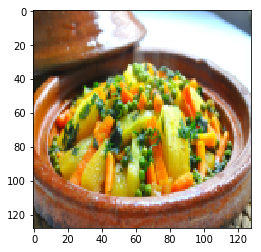

In [4]:
test_img = preprocess_image("tajine.jpg")
color_img = read_color_image("tajine.jpg")
original_color_image = read_color_image("tajine.jpg")
original_gray_image = preprocess_image("tajine.jpg")
plt.imshow(color_img)

##### Préparation du graphe

In [5]:
def is_pixel(i, j, shape):
    return (i<shape[0] and j<shape[1])

In [6]:
def get_edges(img):
    edges=[]
    steps = [0,1]
    shape = img.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            for x in steps:
                for y in steps:
                    if (is_pixel(i+x, j+y, shape) and (x!=0 or y!=0)):
                        edge={}
                        edge['node1'] = (i,j)
                        edge['node2'] = (i+x, j+y)
                        edge['weight'] = abs(img[i][j] - img[i+x][j+y])
                        edges.append(edge)
    return edges

In [7]:
edges = get_edges(test_img)

/home/salma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  del sys.path[0]


In [8]:
len(edges)

48641

In [9]:
edges[100]

{'node1': (0, 33), 'node2': (1, 33), 'weight': 242}

# Étape 1 : Tri des arêtes par ordre croissant des poids

### Algorithme utilisé pour le tri : Merge Sort

######  Fonction permettant de fusionner deux listes d'arêtes tout en respectant l'ordre des poids

In [10]:
def merge(a1, a2, l, m, r) :
	i = l
	j = m
	for k in range(l, r) :
		if i < m and ( j == r or a1[i]["weight"] <= a1[j]["weight"] ) :
			a2[k] = a1[i]
			i += 1
		else :
			a2[k] = a1[j]
			j += 1

###### Fonction permettant de faire le tri d'une sous-liste d'arêtes

In [11]:
def merge_sort_rec(a, tmp, l, r) :
	if l >= r-1 :
		return
	m = int(l + (r-l)/2) # middle point
	merge_sort_rec(a, tmp, l, m)
	merge_sort_rec(a, tmp, m, r)
	for i in range(l, r) :
		tmp[i] = a[i]
	merge(tmp, a, l, m, r)

###### Fonction permettant de faire le tri de toute la liste

In [12]:
def merge_sort(a) :
	tmp = [ {"node1":(0,0),"node2":(0,0),"weight":0} for i in range(len(a)) ]
	merge_sort_rec(a, tmp, 0, len(a))

In [13]:
sorted_edges = edges
merge_sort(sorted_edges)

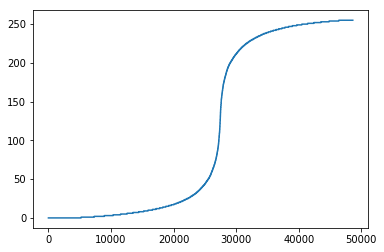

In [14]:
weights = []
for edge in sorted_edges:
    weights.append(edge['weight'])
plt.plot(weights)

À ce stade, on a fait les premiers traitements de l'image.
On a également créé le graphe à travers l'extraction des arêtes avec leurs poids dans une liste où on les a triées par ordre croissant des poids.

# Étape 2 : Contruction des composantes connexes du graphe représentant les régions de l'image

### Algorithme utilisé : Union Set

In [15]:
def set_component_ids(shape):
	component_ids = []
	for i in range(shape[0]):
	    temp = []
	    for j in range(shape[1]):
	        temp.append((i,j))
	    component_ids.append(temp)
	return component_ids

In [16]:
def print_matrix(mat):
    for l in mat:
        print(l)
        print('\n')

In [17]:
def set_component_size(shape):
    component_size = []
    for i in range(shape[0]):
        temp=[]
        for j in range(shape[1]):
            temp.append(1)
        component_size.append(temp)
    return component_size

In [18]:
class Segmentation_Graph:

	def __init__(self,image, edges, component_ids, component_size):
		self.image = image
		self.edges = edges
		self.component_ids = component_ids
		self.shape = image.shape
		self.k = 1000
		self.component_max_weight = []
		self.component_size = component_size
		self.numb_components = image.shape[0] * image.shape[1] 

	def find(self, node):
		root = node 
		while(self.component_ids[root[0]][root[1]] != root):
			root = self.component_ids[root[0]][root[1]]
		while(node != root):
			next = self.component_ids[node[0]][node[1]]
			self.component_ids[node[0]][node[1]] = root
			node = next
		return root


	def connected(self, root1, root2):
		return root1==root2 

	def get_weight(self,edge):
		return edge['weight']

	def get_component_size(self,root):
		return self.component_size[root[0]][root[1]]

	def get_max_weight(self,root):
		max_weight = 0
		for r in self.component_max_weight:
			if (r['root'] == root):
				max_weight = r['max_weight']
				break
		return max_weight

	def union(self,root1, root2, edge):
		if(self.get_component_size(root1) == self.get_component_size(root2) == 1):
			self.component_size[root1[0]][root1[1]] = self.component_size[root1[0]][root1[1]]+1
			self.component_size[root2[0]][root2[1]] = 0
			self.component_ids[root2[0]][root2[1]]=self.component_ids[root1[0]][root1[1]]
			max_weight_dict = {}
			max_weight_dict['root']=root1
			max_weight_dict['max_weight']=self.get_weight(edge)
			self.component_max_weight.append(max_weight_dict)
		elif(self.get_component_size(root1) >= self.get_component_size(root2)):
			self.component_size[root1[0]][root1[1]] = self.component_size[root1[0]][root1[1]] + self.get_component_size(root2)
			self.component_size[root2[0]][root2[1]] = 0
			self.component_ids[root2[0]][root2[1]]=self.component_ids[root1[0]][root1[1]]
			for i in range(len(self.component_max_weight)):
				if (self.component_max_weight[i]['root'] == root1):
					self.component_max_weight[i]['max_weight'] = self.get_weight(edge)
                    
		else:
			self.component_size[root2[0]][root2[1]] = self.component_size[root2[0]][root2[1]]+ self.get_component_size(root1)
			self.component_size[root1[0]][root1[1]] = 0
			self.component_ids[root1[0]][root1[1]]=self.component_ids[root2[0]][root2[1]]
			for i in range(len(self.component_max_weight)):
				if (self.component_max_weight[i]['root'] == root2):
					self.component_max_weight[i]['max_weight'] = self.get_weight(edge)
		self.update_numb_components()
		return 

	def m_int(self,root1, root2):
		max_weight1 = self.get_max_weight(root1)
		max_weight2 = self.get_max_weight(root2)
		t1 = self.k/self.get_component_size(root1)
		t2 = self.k/self.get_component_size(root2)
		return min(max_weight1+t1, max_weight2+t2)

	def boundary(self,root1, root2, edge):
		return self.get_weight(edge)>self.m_int(root1, root2)
	
	def update_numb_components(self):
		self.numb_components -= 1
		return
	def Graph_Based_Segmentation(self):
		for edge in self.edges:
			root1=self.find(edge['node1'])
			root2=self.find(edge['node2'])
			if(self.connected(root1, root2)==False and self.boundary(root1, root2, edge)==False):
				self.union(root1, root2, edge)

In [19]:
segmentation_graph = Segmentation_Graph(test_img, sorted_edges, set_component_ids(test_img.shape),set_component_size(test_img.shape))
segmentation_graph.Graph_Based_Segmentation()

# Visualisation de la sortie de la première phase de segmentation

In [20]:
def get_colors(width, height):
    clrs = []
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    for i in range(height):
        tmp = []
        for j in range(width):
            tmp.append((int(random()*255), int(random()*255), int(random()*255)))
        clrs.append(tmp)
        
    return clrs

In [21]:
def generate_image(segmentation_graph):
    width = segmentation_graph.shape[0]
    height = segmentation_graph.shape[1]
    
    colors = get_colors(width, height)

    img = Image.new('RGB', (width, height))
    im = img.load()
    for y in range(height):
        for x in range(width):
            root = segmentation_graph.find((x,y))
            im[x, y] = colors[root[1]][root[0]]

    return img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)

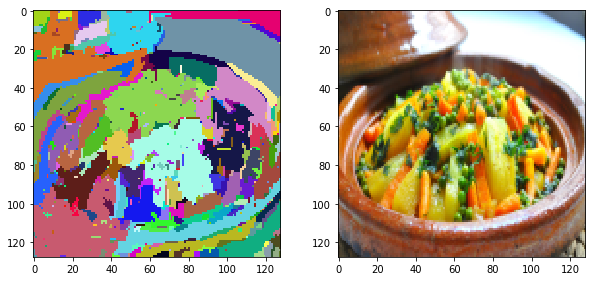

In [22]:
out = generate_image(segmentation_graph)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(out)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(color_img)

In [23]:
segmentation_graph.numb_components

429

# Étape : Fusion des régions similaires

In [24]:
def get_region_dict(segmentation_graph):
    components = {}
    for i in range(segmentation_graph.shape[0]):
        for j in range(segmentation_graph.shape[1]):
            if ((i,j) == segmentation_graph.find((i,j))):
                key = (i,j)
                components[key]=[]
    for i in range(segmentation_graph.shape[0]):
        for j in range(segmentation_graph.shape[1]):
            root = segmentation_graph.find((i,j))
            components[root].append((i,j))
    return components          

In [25]:
region_dict = get_region_dict(segmentation_graph)
len(region_dict)

429

In [26]:
def get_texture(glcm_texture):
    texture = 0
    for t in glcm_texture:
        texture += 1/13 * t
    return texture

In [27]:
def crop_image_for_texture(root, region_dict, image):
    region_list = region_dict[root]
    xmax, xmin =  region_list[0]
    ymax, ymin =  region_list[0]
    
    for region in region_list:
        if (region[0] > xmax):
            xmax=region[0]
        if (region[0] < xmin):
            xmin=region[0]
        if (region[1] > ymax):
            ymax=region[1]
        if (region[1] < ymin):
            ymin=region[1]
    
    return image[xmin:xmax, ymin:ymax]

In [28]:
def get_img_for_texture(image, region_dict):
    region_images = []
    for root in region_dict:
        img = crop_image_for_texture(root, region_dict, image)
        region_images.append(img)
    return region_images

In [30]:
def get_textural_features(image, region_dict):
        textures_dict = {}
        for root in region_dict:
            region_image = crop_image_for_texture(root, region_dict, image)
            if(len(region_image) > 16):
                file_name = str(root)+".png"
                new_im = Image.fromarray(region_image)
                new_im.save(file_name)
                img = cv.cvtColor(cv.imread(file_name), cv.COLOR_BGR2GRAY)
                if(img.shape >= (16,16)):
                    textures = mt.features.haralick(img)
                    ht_mean = textures.mean(axis=0)
                    textures_dict[root] = get_texture(ht_mean)
            
                else:
                    ht_mean = -1
                    textures_dict[root] = ht_mean
            
        
        return textures_dict

In [31]:
def dist_texture(root1, root2, textures_dict):
    texture1 = textures_dict[root1]
    texture2 = textures_dict[root2]
    return abs(texture1-texture2)

In [32]:
textures_dict = get_textural_features(test_img, region_dict)

In [33]:
def region_union(root1, root2, segmentation_graph):
    if(segmentation_graph.get_component_size(root1) > segmentation_graph.get_component_size(root2)):
        segmentation_graph.component_size[root1[0]][root1[1]] = segmentation_graph.component_size[root1[0]][root1[1]] + segmentation_graph.get_component_size(root2)
        segmentation_graph.component_size[root2[0]][root2[1]] = 0
        segmentation_graph.component_ids[root2[0]][root2[1]]=segmentation_graph.component_ids[root1[0]][root1[1]]
        max_weight1, max_weight2 = 0,0
        for i in range(len(segmentation_graph.component_max_weight)):
            if (segmentation_graph.component_max_weight[i]['root'] == root1):
                max_weight1 = segmentation_graph.component_max_weight[i]['max_weight']
            elif(segmentation_graph.component_max_weight[i]['root'] == root2):
                max_weight2 = segmentation_graph.component_max_weight[i]['max_weight']
        max_weight = max(max_weight1, max_weight2)
        for i in range(len(segmentation_graph.component_max_weight)):
            if (segmentation_graph.component_max_weight[i]['root'] == root1):
                segmentation_graph.component_max_weight[i]['max_weight'] = max_weight
    elif(segmentation_graph.get_component_size(root2) > segmentation_graph.get_component_size(root1)):
        segmentation_graph.component_size[root2[0]][root2[1]] = segmentation_graph.component_size[root2[0]][root2[1]] + segmentation_graph.get_component_size(root1)
        segmentation_graph.component_size[root1[0]][root1[1]] = 0
        segmentation_graph.component_ids[root1[0]][root1[1]]=segmentation_graph.component_ids[root2[0]][root2[1]]
        max_weight1, max_weight2 = 0,0
        for i in range(len(segmentation_graph.component_max_weight)):
            if (segmentation_graph.component_max_weight[i]['root'] == root1):
                max_weight1 = segmentation_graph.component_max_weight[i]['max_weight']
            elif(segmentation_graph.component_max_weight[i]['root'] == root2):
                max_weight2 = segmentation_graph.component_max_weight[i]['max_weight']
        max_weight = max(max_weight1, max_weight2)
        for i in range(len(segmentation_graph.component_max_weight)):
            if (segmentation_graph.component_max_weight[i]['root'] == root2):
                segmentation_graph.component_max_weight[i]['max_weight'] = max_weight
    segmentation_graph.update_numb_components()


In [37]:
def remove_small_components(segmentation_graph, textures_dict, min_size):
    for edge in segmentation_graph.edges:
        root1 = segmentation_graph.find(edge['node1'])
        root2 = segmentation_graph.find(edge['node2'])
        size_condition = segmentation_graph.get_component_size(root1) < min_size or segmentation_graph.get_component_size(root2) < min_size
        try:
            texture_condition = dist_texture(root1, root2, textures_dict) < 1000.0
        except:
            texture_condition = True
        if root1 != root2 and size_condition and texture_condition:
            region_union(root1, root2, segmentation_graph)

    return  segmentation_graph

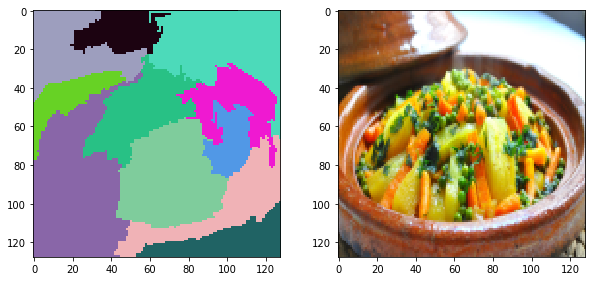

In [38]:
final_segmentation = remove_small_components(segmentation_graph,textures_dict, 512)
out = generate_image(final_segmentation)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(out)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(color_img)

In [39]:
final_segmentation.numb_components

11

# Récupération des objets

In [40]:
final_region_dict = get_region_dict(final_segmentation)

In [41]:
def crop_image(root, region_dict, image, original_image, gray):
    region_list = region_dict[root]
    xmax, xmin =  region_list[0]
    ymax, ymin =  region_list[0]
    
    for region in region_list:
        if (region[0] > xmax):
            xmax=region[0]
        if (region[0] < xmin):
            xmin=region[0]
        if (region[1] > ymax):
            ymax=region[1]
        if (region[1] < ymin):
            ymin=region[1]

    if(gray == True):
        
        for x in range(xmin,xmax):
            image[x,ymin] = [255,255,255]
            image[x,ymax] = [255,255,255]
        
        for y in range(ymin,ymax):
            image[xmax,y] = [255,255,255] 
            image[xmin,y] = [255,255,255]
    else:
        for x in range(xmin,xmax):
            image[x,ymin] = 255
            image[x,ymax] = 255
        
        for y in range(ymin,ymax):
            image[xmax,y] = 255 
            image[xmin,y] = 255
    
    return original_image[xmin:xmax, ymin:ymax]

In [42]:
def region_to_image(region_dict, image, original_image, gray):
    object_images = []
    for root in region_dict:
        img = crop_image(root, region_dict, image, original_image, gray)
        object_images.append(img)
    return object_images

In [43]:
object_images = region_to_image(final_region_dict, color_img, original_color_image, False)
gray_object_images = region_to_image(final_region_dict, color_img, original_gray_image, True)

In [44]:
len(object_images)

11

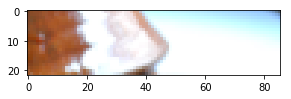

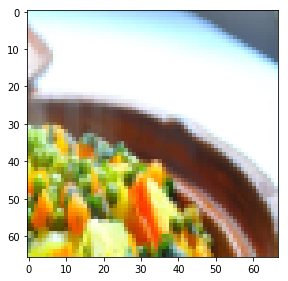

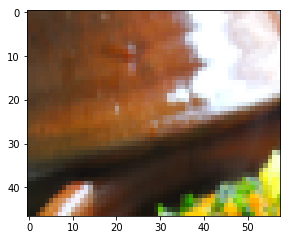

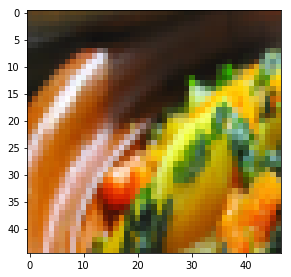

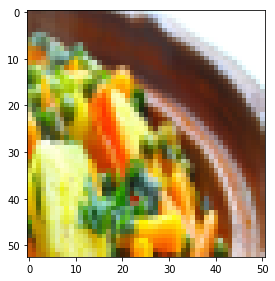

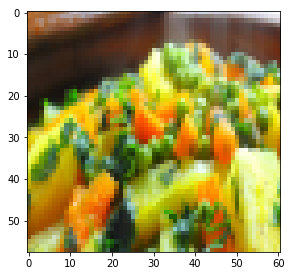

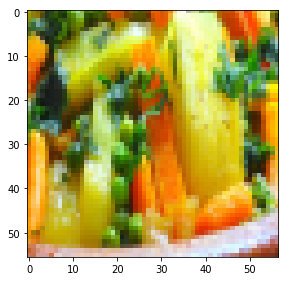

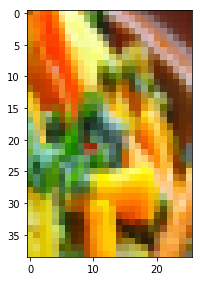

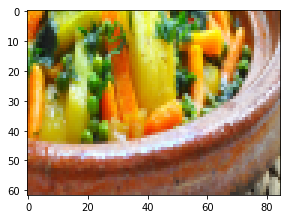

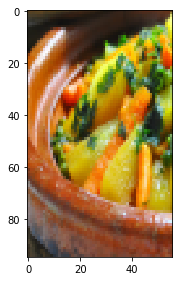

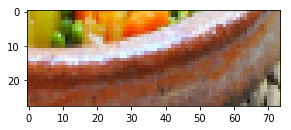

In [45]:
for i in object_images:
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(i)

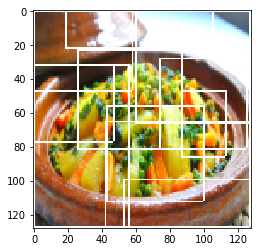

In [46]:
plt.imshow(color_img)

# Classification (exemple du classificateur de pommes de terre)

In [47]:
def load_images(data_dir,images, labels, dim, x):
    i = 0
    file_names = [os.path.join(data_dir, f)
                for f in os.listdir(data_dir) if f.endswith(".png")]
           #     if f.endswith(".png") or f.endswith(".jpg") or f.endswith(".jpeg")]
    for f in file_names:
        img = cv.cvtColor(cv.imread(f), cv.COLOR_BGR2GRAY)
        image = cv.resize(img, (dim,dim), interpolation = cv.INTER_AREA)
        images.append(image)
        labels.append(x)
        i+=1
    return i

In [48]:
labels = []
images = []
p = load_images("pomme_de_terre",images,labels, 28, 0)
c = load_images("courgette",images, labels, 28, 1)
k = load_images("carotte",images, labels, 28, 1)
train_images = np.asarray(images)
train_labels = np.asarray(labels)

# Configuration et entrainement du modèle

In [49]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [50]:
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [64]:
history = model.fit(train_images, train_labels, epochs=100)

Epoch 1/100
18/18 [==============================] - 0s 2ms/step - loss: 1.2192 - accuracy: 0.8891
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.9243
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.9261
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 1.0221 - accuracy: 0.8908
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 1.7029 - accuracy: 0.8627
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 1.4087 - accuracy: 0.8539
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.5566 - accuracy: 0.9208
Epoch 8/100
18/18 [==============================] - 0s 2ms/step - loss: 0.4980 - accuracy: 0.9296
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 1.0643 - accuracy: 0.8609
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.9331
Epoch 11/

18/18 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9630
Epoch 84/100
18/18 [==============================] - 0s 3ms/step - loss: 0.6142 - accuracy: 0.9313
Epoch 85/100
18/18 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.9173
Epoch 86/100
18/18 [==============================] - 0s 2ms/step - loss: 0.5067 - accuracy: 0.9261
Epoch 87/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9595
Epoch 88/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.9665
Epoch 89/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2766 - accuracy: 0.9437
Epoch 90/100
18/18 [==============================] - 0s 2ms/step - loss: 3.4886 - accuracy: 0.7658
Epoch 91/100
18/18 [==============================] - 0s 2ms/step - loss: 4.8862 - accuracy: 0.7553
Epoch 92/100
18/18 [==============================] - 0s 2ms/step - loss: 2.2805 - accuracy: 0.8574
Epoch 93/100


# Visualisation du taux de réussite et du taux d'erreur

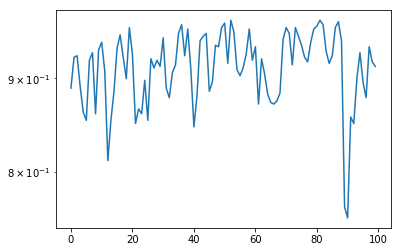

In [70]:
epochs = range(0,100)
acc = history.history['accuracy']
plt.yscale('log')
plt.plot(acc)

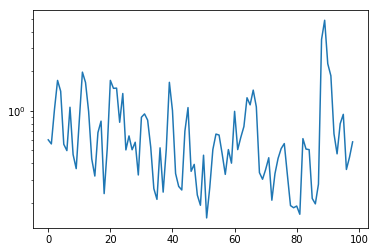

In [71]:
loss_val = history.history['loss']
plt.yscale('log')
plt.plot(loss_val[1:])

# Test du modèle de "pomme de terre" sur les segment de l'image test

In [52]:
def resize(object_images, dim):
    test_images = []
    for i in range(len(object_images)):
        object_images[i] = cv.resize( object_images[i], (dim,dim), interpolation = cv.INTER_AREA)
        file_name = str(i)+".png"
        new_im = Image.fromarray(object_images[i])
        new_im.save(file_name)
        img = cv.cvtColor(cv.imread(file_name), cv.COLOR_BGR2GRAY)
        test_images.append(img)
    return np.asarray(test_images)

In [53]:
tst_images = resize(gray_object_images, 28)

In [54]:
predictions = model.predict(tst_images)

In [55]:
predictions

array([[1.1231148e-19, 1.0000000e+00],
       [3.0037567e-10, 1.0000000e+00],
       [9.6836624e-28, 1.0000000e+00],
       [9.9999285e-01, 7.1405725e-06],
       [0.0000000e+00, 1.0000000e+00],
       [1.9672923e-16, 1.0000000e+00],
       [9.9999988e-01, 1.1585931e-07],
       [9.9999988e-01, 9.4992487e-08],
       [2.7197438e-23, 1.0000000e+00],
       [5.6925246e-17, 1.0000000e+00],
       [7.3424154e-22, 1.0000000e+00]], dtype=float32)

In [59]:
label_list=['pomme de terre', 'autre']

In [72]:
def get_result(predictions):
    m = 0
    for j in range(len(predictions)):
        m=max(predictions[j])
        if (m > 0.5):
            print("Ce plat contient des pommes de terre")
            return
    print("Ce plat ne contient pas de pommes de terre")
    return
    

In [73]:
get_result(predictions)

Ce plat contient des pommes de terre
